# Introduction
## Loss Functions
Decision Tree use loss functions that evaluate the split based on the purity of the resulting nodes.

We have 3 choices for loss functions:

1. Gini Impurity Index:

Gini Impurity is measure of variance across the different classes

$ G(Node_{i}) = \sum \limits_{i=1}^{N} {p_{i}} (1-p_{i}) $


2. Entropy : 

Similar to Gini Impurity, Entropy is a measure of chaos within the node. 

$ E(Node_{i}) = -\sum \limits_{i=1}^{N} {p_{i}}log_{2}(p_{i}) $
3. Misclassification Error

$ M(N_{i}) = 1 - max_{i} p_{i} $

where $p_{i} = N_{i}/N $, is the proportion of number of observations at leaf i ($N_{i}$) to total observations (N)

## Data Transformations 

Decision trees are prone to orientation of the training data and prefer orthogonal decision boundaries. Training sets which are lineary separable generalize better than the ones which are not.
For example, in the image below [3] we can see a linearly separable dataset on the left, which can easliy be split up using a decision tree, while on the right side we have the same dataset after 45 degree rotation, the decision boundary becomes complex. 
![DataRotation.png](attachment:DataRotation.png)

Best way to limit this problem is to use <b>Principal Component Analysis (PCA)</b>, which involves projection of original dataset into a hyperplane comprising of orthogonal principal components while preserves maximum amount of variance of the original features.

# Implementation Tasks

## 1. Preparing Dataset and Extracting Features

I have used yahoo finance to extract daily OHLCV data for Bitocin/USD ticker. I have then constructed features based on the table provided in the question set.

The features considered below are:

1. Today's Open - Yesterday's Close (OmC)
1. Yesterday's High - Yesterday's Low (HmL)
1. Returns (1 Day, 5 Day and 10 Day Lags)
1. Momentum ( 3 Day, 5 Day and 10 Day Lags)
1. Simple Moving Averages (SMA, 5 Day, 10 Day and 30 Day Lags)

The dependent variable is the 1 Day Move Direction which is constructed based on 1 Day returns exceeding the threshold. I have considered the median returns to be the threshold for this analyis to make the dataset balanced.



$Y(Move Direction) = \begin{cases}
    1 ,& \text{if } Return\geq 0\\
    0,              & \text{otherwise}
\end{cases} $

In [28]:
# Import required libraries
import pandas as pd
import numpy as np
import os as os
# Import yahoo finance libraries
import yfinance as yf

# Data Processing
from sklearn.preprocessing import StandardScaler

# Visualizaiton
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import Image
#TrainTest Splitting

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer,classification_report

#Hyperparameter FineTuning 

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split, KFold,cross_val_score

#Decision Trees
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

#Ensembles
from sklearn.ensemble import AdaBoostClassifier,AdaBoostRegressor

# XGBoost Classifier
from xgboost import XGBClassifier, plot_importance, Booster, plot_tree, to_graphviz, DMatrix

#Performance Metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix,roc_curve, roc_auc_score

#import pyfolio as pf
#conda install graphviz

In [29]:
OHLCV = yf.download('BTC-USD', start='2016-11-01', end='2022-11-01', progress=False)
OHLCV

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-11-01,701.336975,736.452026,701.336975,729.793030,729.793030,130527000
2016-11-02,730.065979,740.828979,722.348999,740.828979,740.828979,84865200
2016-11-03,742.346008,745.773010,678.156006,688.700012,688.700012,172808000
2016-11-04,689.124023,706.929993,685.562988,703.234985,703.234985,99907696
2016-11-05,703.525024,707.510010,697.739014,703.418030,703.418030,53752300
...,...,...,...,...,...,...
2022-10-28,20287.957031,20724.980469,20086.068359,20595.351562,20595.351562,43994715910
2022-10-29,20595.103516,20988.394531,20566.484375,20818.476562,20818.476562,40369840645
2022-10-30,20817.982422,20917.005859,20547.462891,20635.603516,20635.603516,31486345556


In [30]:
from utils.technical_indicators import SMA, Momentum

In [41]:
Features = pd.DataFrame(data=None,index=OHLCV.index)

Features['Returns'] = OHLCV['Close'].pct_change()
Features['ReturnLag1'] = OHLCV['Close'].pct_change().shift(periods=1)
Features['ReturnLag5'] = OHLCV['Close'].pct_change().shift(periods=5)
Features['ReturnLag10'] = OHLCV['Close'].pct_change().shift(periods=10)

Features['SMA_5Day'] = SMA(OHLCV['Close'],5)
Features['SMA_10Day'] = SMA(OHLCV['Close'],10)
Features['SMA_30Day'] = SMA(OHLCV['Close'],30)

Features['Momentum3day'] = Momentum(OHLCV['Close'],3)
Features['Momentum5day'] = Momentum(OHLCV['Close'],5)
Features['Momentum10day'] = Momentum(OHLCV['Close'],10)

Features['VWaP_5Day'] = SMA(OHLCV['Volume'],5)
Features['VWaP_10Day'] = SMA(OHLCV['Volume'],10)

Features.loc[Features['Returns'].between(-.004, .004) ,'Returns'] =0
Features.loc[Features['Returns']>0 ,'MoveDirection'] = 1
Features.loc[Features['Returns']<0 ,'MoveDirection'] = 0

Features = Features.dropna()
Features

,Returns,ReturnLag1,ReturnLag5,ReturnLag10,SMA_5Day,SMA_10Day,SMA_30Day,Momentum3day,Momentum5day,Momentum10day,VWaP_5Day,VWaP_10Day,MoveDirection
Date,,,,,,,,,,,,,
2016-12-01,0.014863,0.013713,-0.008450,0.011247,0.005780,0.002388,0.001396,20.960999,21.391968,17.526001,6.950684e+07,7.626736e+07,1.0
2016-12-02,0.027974,0.014863,-0.004551,0.016367,0.012285,0.003549,0.001824,42.339966,45.908997,26.596985,8.450748e+07,7.603726e+07,1.0
2016-12-03,-0.008727,0.027974,0.005161,-0.008988,0.009508,0.003575,0.003879,25.464050,35.342041,26.561035,8.603922e+07,7.533761e+07,0.0
2016-12-05,-0.019605,0.003523,0.013713,0.001837,0.003606,0.002362,0.002630,-19.243958,13.009033,17.051025,8.890702e+07,7.665701e+07,0.0
2016-12-06,0.007281,-0.019605,0.014863,-0.008450,0.002089,0.003935,0.002489,-6.931030,7.450012,28.841980,9.605824e+07,8.278254e+07,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-27,-0.023331,0.033568,0.001863,0.014670,0.011277,0.003885,0.002127,940.263672,1077.646484,735.078125,4.172272e+10,3.346767e+10,0.0
2022-10-28,0.015258,-0.023331,0.018680,-0.011066,0.010592,0.006517,0.002084,499.494141,1028.343750,1260.935547,4.609591e+10,3.480914e+10,1.0
2022-10-29,0.010834,0.015258,-0.011317,-0.010079,0.015022,0.008609,0.002194,48.035156,1472.904297,1678.941406,4.812943e+10,3.660359e+10,1.0


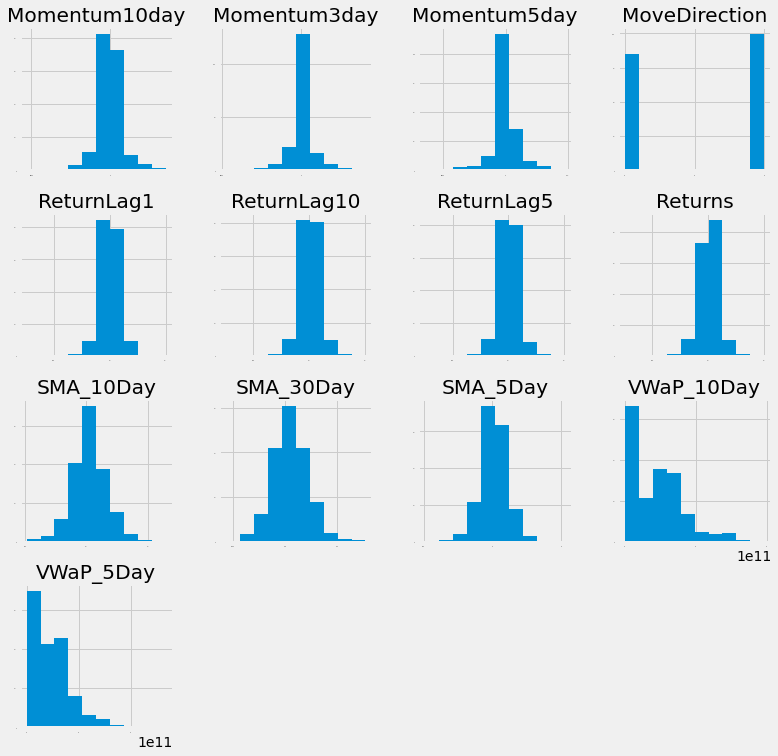

In [42]:
# histograms
Features.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

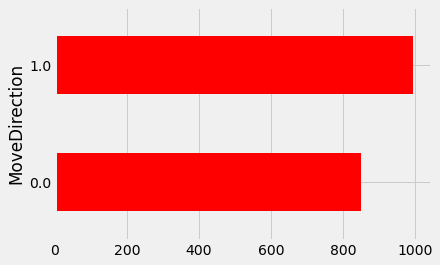

In [43]:
fig = plt.figure()
plot = Features.groupby(['MoveDirection']).size().plot(kind='barh', color='red')
plt.show()

In [78]:
X = Features[Features.columns.drop(['Returns','MoveDirection'])]
y = Features[['MoveDirection']]

featurelist = X.columns
target = y.columns

In [79]:
from scipy.stats import pearsonr
correlations = {}

for f in featurelist:
    x1 = X[f].values
    x2 = y.values
    key = f + ' vs ' + 'target'
    correlations[f] = pearsonr(x1,x2)[0]
    

In [81]:
# Printing all the correlated features value with respect to price which is target variable
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
SMA_5Day,0.323376
Momentum3day,0.315791
Momentum5day,0.24454
SMA_10Day,0.230398
Momentum10day,0.17025
SMA_30Day,0.151814
VWaP_10Day,-0.0584337
VWaP_5Day,-0.0565105
ReturnLag1,-0.0503223
ReturnLag10,0.023556


In [83]:
X = Features[X.columns.drop(['VWaP_10Day','VWaP_5Day','ReturnLag1','ReturnLag5'])]

In [84]:
# Splitting the datasets into training and testing data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True,random_state=24)

# Output the train and test data size
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 1476, 369


### Training a Decision Tree

In [95]:
#Unpruned Tree
fulldecisionTree =  DecisionTreeClassifier(random_state =42)

fulldecisionTree.fit(X_train,y_train)

fulldecisionTree.score(X_test,y_test) 

fulldecisionTree.get_params()

#fig = plt.figure(figsize=(100,100))
#tree.plot_tree(decisionTree, feature_names=None,class_names=None,filled=True)

dot_data = tree.export_graphviz(fulldecisionTree, out_file=None, 
                                feature_names=list(X_test.columns),  
                                class_names=['Down','Up'],
                                filled=True)

graph = graphviz.Source(dot_data, format="png") 
graph.render("decision_tree_graphivz")


'decision_tree_graphivz.png'

In [96]:
depth_FullyGrownTree = fulldecisionTree.get_depth()
print("Maximum depth of tree is : "  + str(depth_FullyGrownTree))

Maximum depth of tree is : 19


In [93]:
print(classification_report(y_test,fulldecisionTree.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.58      0.59      0.58       169
         1.0       0.64      0.64      0.64       200

    accuracy                           0.61       369
   macro avg       0.61      0.61      0.61       369
weighted avg       0.61      0.61      0.61       369



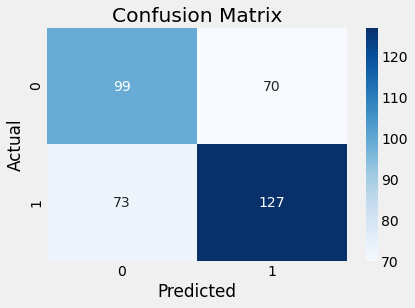

In [94]:
cm1= confusion_matrix(y_test,fulldecisionTree.predict(X_test))

temp1 = pd.DataFrame(cm1, index=['0', '1'], columns=['0', '1'])

sns.heatmap(temp1, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The fully grown tree perfectly fits (or Overfits) the training set. We will try resolve the problem using pruning in next section and also try to improve the prediction of negative moves by finding hyperparameters that <b> optimize precision and recall scores (f1 Score) </b>

### HyperParameter Tuning 

I have used Grid Search to perform hyper parameter tuning where we find optimal values of <b> maximum depth </b> (default value is none), <b> minimum samples required for a split </b> and <b> minimum samples required for a node to be a leaf </b>.

1.  Decision trees are prone to over fitting and makes the decision rules more complex. Pruning helps prevent overfitting and simplifies it by limiting the depth and setting minimum 

1.  Pruning should ensure that the subtree is optimal i.e it has the highest accuracy(or any other chosen metric) on the cross-validated training set.

1. The search for the optimal subtree should be computationally tractable.

Essentially, pruning recursively finds the node with the “weakest link.” The weakest link is characterized by an effective alpha, where the nodes with the smallest effective alpha are pruned first.

$ R_{\alpha}(T) = R (T) + \alpha \lvert{T}\rvert  $

where:
$R(T)$ — Total training error of leaf nodes <br>
$\alpha \lvert{T}\rvert$ — The number of leaf nodes <br>
$\alpha$ — complexity parameter(a whole number)

In [85]:
from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

std_slc = StandardScaler()
pca = decomposition.PCA()
dec_tree = tree.DecisionTreeClassifier()

pipe = Pipeline(steps=[('std_slc', std_slc),
                        ('pca', pca),
                        ('dec_tree', dec_tree)])

In [98]:
#Creating a Pipeline for GridSearchCV
pipe = Pipeline(steps=[('std_slc', std_slc),
                        ('pca', pca),
                        ('dec_tree', dec_tree)])
n_components = list(range(1,X.shape[1]+1,1))     #No Of PCs to keep after dim reduction
criterion = ['gini', 'entropy']
#max_depth = [2,4,6,8,10,12]
max_depth =  range(1,depth_FullyGrownTree,1)
min_samples_split =  [2,10,20,40,80]
min_samples_leaf = [1,10,20,40,80]

parameters = dict(pca__n_components=n_components,
                    dec_tree__criterion=criterion,
                    dec_tree__max_depth=max_depth,
                    dec_tree__min_samples_split=min_samples_split,
                    dec_tree__min_samples_leaf = min_samples_leaf)

In [99]:
clf_GS = GridSearchCV(pipe, parameters)
clf_GS.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('std_slc', StandardScaler()),
                                       ('pca', PCA()),
                                       ('dec_tree', DecisionTreeClassifier())]),
             param_grid={'dec_tree__criterion': ['gini', 'entropy'],
                         'dec_tree__max_depth': range(1, 19),
                         'dec_tree__min_samples_leaf': [1, 10, 20, 40, 80],
                         'dec_tree__min_samples_split': [2, 10, 20, 40, 80],
                         'pca__n_components': [1, 2, 3, 4, 5, 6, 7]})

In [101]:
print('Best Criterion:', clf_GS.best_estimator_.get_params()['dec_tree__criterion'])
print('Best max_depth:', clf_GS.best_estimator_.get_params()['dec_tree__max_depth'])
print('Best min_samples_leaf:', clf_GS.best_estimator_.get_params()['dec_tree__min_samples_leaf'])
print('Best min_samples_split:', clf_GS.best_estimator_.get_params()['dec_tree__min_samples_split'])
print('Best Number Of Components:', clf_GS.best_estimator_.get_params()['pca__n_components'])
print(); print(clf_GS.best_estimator_.get_params()['dec_tree'])

Best Criterion: gini
Best max_depth: 6
Best min_samples_leaf: 10
Best min_samples_split: 40
Best Number Of Components: 1

DecisionTreeClassifier(max_depth=6, min_samples_leaf=10, min_samples_split=40)


In [102]:
print(classification_report(y_test,clf_GS.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.62      0.61      0.62       169
         1.0       0.68      0.69      0.68       200

    accuracy                           0.65       369
   macro avg       0.65      0.65      0.65       369
weighted avg       0.65      0.65      0.65       369



Area under ROC Curve : 0.649734


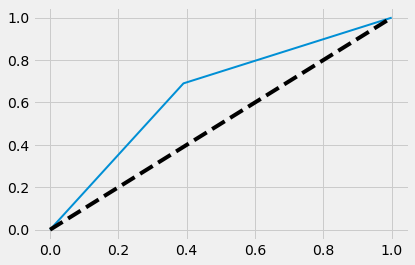

In [103]:
fpr,tpr, thresholds = roc_curve(y_test, clf_GS.predict(X_test))

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal

print('Area under ROC Curve : %f'%roc_auc_score(y_test, clf_GS.predict(X_test)))
plot_roc_curve(fpr, tpr)
plt.show()

In [104]:
Importance = pd.DataFrame({'Importance':clf_GS.best_estimator_.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

AttributeError: 'Pipeline' object has no attribute 'feature_importances_'

# Ensemble Learning
Based on the above results AdaBoost performs the best amongst all the alternative models considered.Boosting algorithms typically convert weak leaners to strong learners.The principal behind boosting is algorithms is first we built a model on the training set and then the second model is built to rectify the errors in the first model. The procedure is continued until and unless the errors are minimized and the dataset is predicted correctly.

The first one (Adaboost, for adaptive boosting) improves the learning process by progressively focusing on the instances that yield the largest errors. The second one (xgboost) is a flexible algorithm in which each new tree is only focused on the minimization of the training sample loss.

Empirical design of Adaboost is as follows:

1. When training an AdaBoost classifier, the algorithm first trains a base classifier (such as a Decision Tree) and uses it to make predictions on the training set.

1. The algorithm then increases the relative weight of misclassified training instances.(See figure below [3])

![AdaBoost%20Sequential%20training.png](attachment:AdaBoost%20Sequential%20training.png)
1. Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, except that predictors have different weights depending on theiroverall accuracy on the weighted training set.

In [ ]:
Ada = AdaBoostClassifier(DecisionTreeClassifier(),
                          n_estimators=300, random_state=42)
Ada.fit(X_train, y_train['MoveDirection'].ravel())

print("Adaboost Model Accuracy: ",Ada.score(X_test,y_test))

In [ ]:
# Scale and fit the classifier model
xgbcls =  XGBClassifier(verbosity = 0, silent=True, random_state=42)
xgbcls.fit(np.array(X_train), y_train['MoveDirection'].ravel())

print("Untuned XGBoost Accuracy:",xgbcls.score(X_test,y_test))

In [ ]:
# Grid Search: Ada boost Algorithm Tuning 
'''
n_estimators : integer, optional (default=50)
    The maximum number of estimators at which boosting is terminated. 
    In case of perfect fit, the learning procedure is stopped early.
''' 
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [10, 50, 100, 500, 1000, 5000]
param_grid = dict(n_estimators=n_estimators)
model = AdaBoostClassifier()
num_folds =3
seed =42
kfold = KFold(n_splits=num_folds,shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=kfold)
grid_result = grid.fit(rescaledX, y_train['MoveDirection'].ravel())

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))